In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import cv2
import time

from collections import defaultdict
from io import StringIO
import matplotlib.pyplot as plt
from PIL import Image
import os.path

%matplotlib inline

In [2]:
from utils import label_map_util
from utils import visualization_utils as vis_util

from fashion_utils import *

In [3]:
sys.path.append("..")

Model preparation 

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  
By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.


In [4]:
# What model to download.

MODEL_NAME = 'trained-inference-graphs/output_inference_graph_v1.pb/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('training/', 'clothing-detection.pbtxt')

NUM_CLASSES = 1

In [5]:
## Load a (frozen) Tensorflow model into memory.
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [6]:
## Loading label map
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [7]:
len(os.listdir('img'))

123016

In [8]:
class IdentityMetadata():
    def __init__(self, name, file):
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for f in os.listdir(path):
        # Check file extension. Allow only jpg/jpeg' files.
        ext = os.path.splitext(f)[1]
        if ext == '.jpg' or ext == '.jpeg':
            metadata.append(IdentityMetadata(path,f))
    return np.array(metadata)


In [27]:
### images 
IMAGE_PATHS = load_metadata('img')
IMAGE_PATHS

array([img/img_00117352.jpg, img/img_00024108.jpg, img/img_00096643.jpg,
       ..., img/img_00008259.jpg, img/img_00084517.jpg,
       img/img_00096558.jpg], dtype=object)

In [28]:
from progressbar import ProgressBar
import warnings
warnings.filterwarnings('ignore')

In [29]:
## checking for only first 200 images
IMAGE_PATHS = IMAGE_PATHS[:200]

### Clothing segmentation

In [30]:
num_images = IMAGE_PATHS.shape[0]
progress = ProgressBar(num_images)
progress.start()

clothes = []
orig_images = []
temp_paths = []
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        for i,image_path in enumerate(IMAGE_PATHS):
            image = Image.open(str(image_path))
            image_np = load_image_into_numpy_array(image)
            ## Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            ## Each box represents a part of the image where a particular object was detected.
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            
            ## Each score represent how level of confidence for each of the objects.
            ## Score is shown on the result image, together with the class label.
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            ## Actual detection.
            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
            
            ## Visualization of the results of a detection.
            temp = vis_util.extract_clothes_from_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=8)
            
            temp = np.array(temp)
            if(temp.shape[0]>0):
                temp_paths.append(image_path)
                cloth = extract_cloth(image,temp)
                orig_images.append(image_np)
                clothes.append(cloth)
            progress.update(i)
            
IMAGE_PATHS = temp_paths

In [31]:
np.save("fashion.npy",clothes)
np.save("images.npy", orig_images)
# faces = np.load('faces.npy', allow_pickle=True)

In [32]:
len(clothes)

140

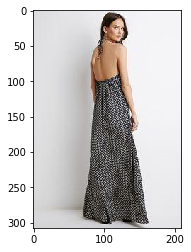

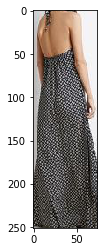

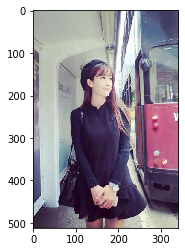

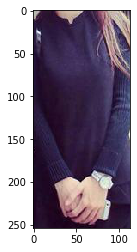

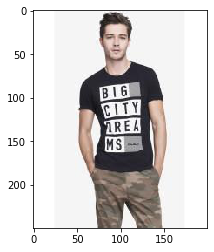

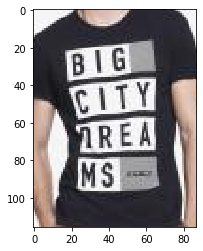

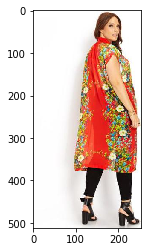

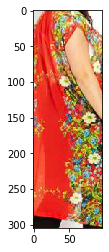

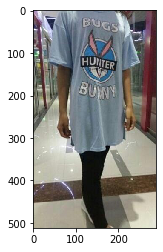

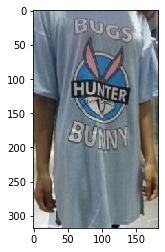

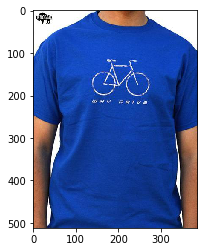

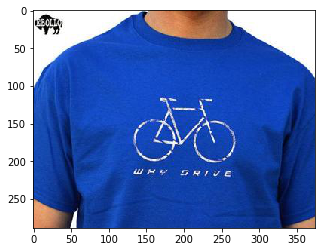

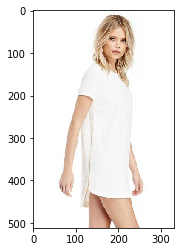

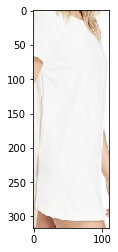

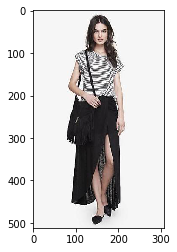

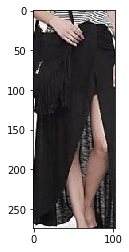

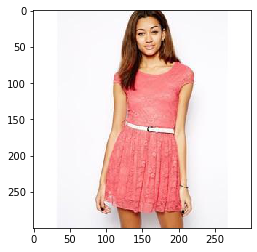

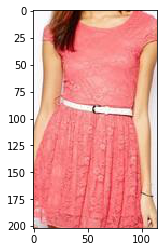

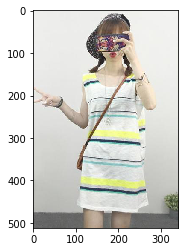

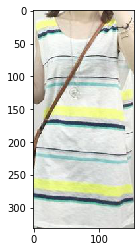

In [33]:
%matplotlib inline
for i in range(10):
    plt.figure()
    plt.imshow(orig_images[i])
    plt.figure()
    plt.imshow(clothes[i])

------------------------

### Webcam

In [37]:
# fourcc = cv2.VideoWriter_fourcc(*'XVID')
# out = cv2.VideoWriter('output.avi',fourcc,12.0, (800,600))

In [ ]:
# cap = cv2.VideoCapture(0)

# with detection_graph.as_default():
#     with tf.Session(graph=detection_graph) as sess:
#         count = 0
#         start = time.time() ###
#         while True:
#             ret, image_np = cap.read()
#             count = count + 1
#             # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
#             image_np_expanded = np.expand_dims(image_np, axis=0)
#             image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
#             # Each box represents a part of the image where a particular object was detected.
#             boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
#             # Each score represent how level of confidence for each of the objects.
#             # Score is shown on the result image, together with the class label.
#             scores = detection_graph.get_tensor_by_name('detection_scores:0')
#             classes = detection_graph.get_tensor_by_name('detection_classes:0')
#             num_detections = detection_graph.get_tensor_by_name('num_detections:0')
#             # Actual detection.
#             (boxes, scores, classes, num_detections) = sess.run(
#                 [boxes, scores, classes, num_detections],
#                 feed_dict={image_tensor: image_np_expanded})
#             # Visualization of the results of a detection.
#             vis_util.visualize_boxes_and_labels_on_image_array(
#                 image_np,
#                 np.squeeze(boxes),
#                 np.squeeze(classes).astype(np.int32),
#                 np.squeeze(scores),
#                 category_index,
#                 use_normalized_coordinates=True,
#                 line_thickness=8)
#             fr = cv2.resize(image_np, (800,600))
#             cv2.imshow('object detection',fr)
#             out.write(fr)
#             if cv2.waitKey(25) & 0xFF == ord('q'):
#                 cap.release()
#                 out.release()
#                 cv2.destroyAllWindows()
#                 break
#         end = time.time()
#         seconds = end - start
#         print("Time taken : {0} seconds".format(seconds))
#         # Calculate frames per second
#         fps  = count / seconds;
#         print("Estimated frames per second : {0}".format(fps))

--------------------------